In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
import time

In [99]:
data = pd.read_csv('data/College.csv').drop(columns='Unnamed: 0').dropna()
data = pd.get_dummies(data, columns=['Private'], drop_first=True)
data

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
2,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
3,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
4,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40,0
773,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83,1
774,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49,1
775,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99,1


<Figure size 864x864 with 0 Axes>

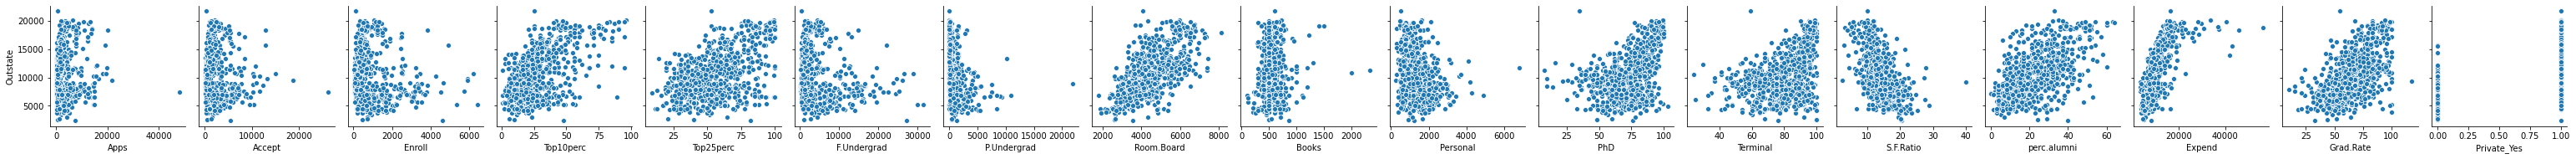

In [100]:
plt.figure(figsize=(12,12))
sb.pairplot(data=data, x_vars=X.columns, y_vars='Outstate')

In [101]:
X = data.drop(columns='Outstate')
y = data['Outstate']

In [102]:
# Perform Forward Stepwise Selection
def forward_stepwise(predictors):
    
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]

    tic = time.time()

    results = []

    cv = KFold(n_splits=10, random_state=None, shuffle=False)

    for p in remaining_predictors:
        features_set = list(predictors + [p])

        # Crossvalidation with K-folds
        lm = LinearRegression()
        score = cross_val_score(lm, X[features_set], y, cv=cv, scoring='neg_mean_squared_error')
        model = sm.OLS(y, X[features_set]).fit()
        results.append({"model": model, "predictors": features_set, "MSE": np.mean(np.abs(score))})

    # Wrap result up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose model with the highest R2
    best_model = models.loc[models['MSE'].argmin()]

    toc = time.time()

    print('Processed {:3} models on {:2} predictors in {:6.2f} seconds.'.format(models.shape[0], len(predictors)+1, (toc-tic)))
    return best_model

In [60]:
models_fwd = pd.DataFrame(columns=['model','predictors','MSE'])

tic = time.time()
predictors = []

for i in range(1, len(X.columns)+1):
    models_fwd.loc[i] = forward_stepwise(predictors)
    predictors = list(models_fwd.loc[i,'predictors'])

toc = time.time()
print('Total elapsed time: {:.2f} seconds.'.format(toc-tic))

Processed  17 models on  1 predictors in   0.60 seconds.
Processed  16 models on  2 predictors in   0.53 seconds.
Processed  15 models on  3 predictors in   0.53 seconds.
Processed  14 models on  4 predictors in   0.51 seconds.
Processed  13 models on  5 predictors in   0.49 seconds.
Processed  12 models on  6 predictors in   0.44 seconds.
Processed  11 models on  7 predictors in   0.41 seconds.
Processed  10 models on  8 predictors in   0.38 seconds.
Processed   9 models on  9 predictors in   0.39 seconds.
Processed   8 models on 10 predictors in   0.36 seconds.
Processed   7 models on 11 predictors in   0.30 seconds.
Processed   6 models on 12 predictors in   0.26 seconds.
Processed   5 models on 13 predictors in   0.20 seconds.
Processed   4 models on 14 predictors in   0.17 seconds.
Processed   3 models on 15 predictors in   0.12 seconds.
Processed   2 models on 16 predictors in   0.08 seconds.
Processed   1 models on 17 predictors in   0.04 seconds.
Total elapsed time: 5.86 second

In [61]:
def add_metrics_table(models):
    models['R2'] = models.apply(lambda x: x['model'].rsquared, axis=1)    
    models['R2_adj'] = models.apply(lambda x: x['model'].rsquared_adj, axis=1)
    models['AIC'] = models.apply(lambda x: x['model'].aic, axis=1)
    models['BIC'] = models.apply(lambda x: x['model'].bic, axis=1)

In [62]:
add_metrics_table(models_fwd)
models_fwd

,model,predictors,MSE,R2,R2_adj,AIC,BIC
1,<statsmodels.regression.linear_model.Regressio...,[Expend],9.122054e+06,0.876037,0.875877,15072.150810,15076.806250
2,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes]",6.514936e+06,0.931966,0.931791,14607.964499,14617.275380
3,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board]",5.286894e+06,0.959003,0.958844,14216.402739,14230.369060
4,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni]",4.713985e+06,0.963460,0.963271,14128.980052,14147.601814
5,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni,...",4.425372e+06,0.964032,0.963799,14118.727913,14142.005115
6,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni,...",4.282765e+06,0.964527,0.964251,14109.952037,14137.884679
7,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni,...",4.263586e+06,0.966316,0.966010,14071.748571,14104.336654
8,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni,...",4.247791e+06,0.967660,0.967323,14042.112706,14079.356229
9,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni,...",4.228071e+06,0.967943,0.967567,14037.283255,14079.182218
10,<statsmodels.regression.linear_model.Regressio...,"[Expend, Private_Yes, Room.Board, perc.alumni,...",4.181365e+06,0.968309,0.967896,14030.347583,14076.901986


In [63]:
# Function display 4 charts on single model
def display_chart_models(models):
    plt.figure(figsize=(12,12))

    plt.subplot(2,2,1)
    sb.lineplot(x=models.index, y=models['R2'])
    max_R2 = models['R2'].max()
    plt.plot(models[models['R2']==max_R2].index, max_R2, 'ro')
    plt.xticks(models.index)

    plt.subplot(2,2,2)
    sb.lineplot(x=models.index, y=models['R2_adj'])
    max_R2_adj = models['R2_adj'].max()
    plt.plot(models[models['R2_adj']==max_R2_adj].index, max_R2_adj, 'ro')
    plt.xticks(models.index)

    plt.subplot(2,2,3)
    sb.lineplot(x=models.index, y=models['AIC'])
    min_AIC = models['AIC'].min()
    plt.plot(models[models['AIC']==min_AIC].index, min_AIC, 'ro')
    plt.xticks(models.index)

    plt.subplot(2,2,4)
    sb.lineplot(x=models.index, y=models['BIC'])
    min_BIC = models['BIC'].min()
    plt.plot(models[models['BIC']==min_BIC].index, min_BIC, 'ro')
    plt.xticks(models.index)

    plt.show()

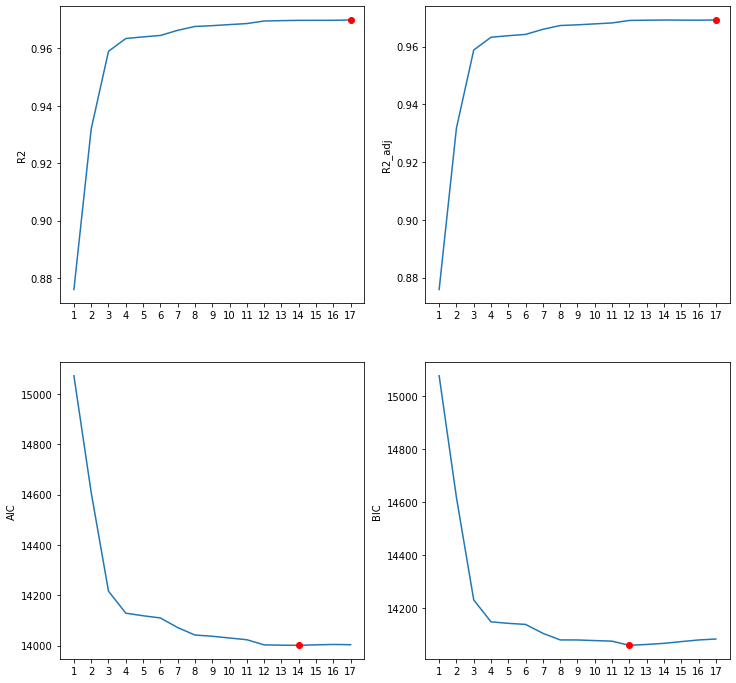

In [64]:
display_chart_models(models_fwd)

In [103]:
# Choose model at 6 predictors
features_set = models_fwd.loc[6,'predictors']
features_set

['Expend', 'Private_Yes', 'Room.Board', 'perc.alumni', 'PhD', 'Grad.Rate']

<Figure size 864x864 with 0 Axes>

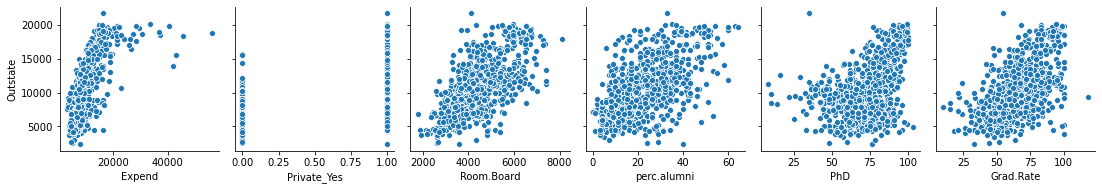

In [111]:
plt.figure(figsize=(12,12))
sb.pairplot(data=data, x_vars=features_set, y_vars='Outstate')

In [104]:
# Create function to check non-linear optimal degree
def result_spline_cr_mse(X, y):
    mse_mean = pd.Series([])
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    lm = LinearRegression()            
    mse_1 = -cross_val_score(lm, X, y, cv=cv, scoring='neg_mean_squared_error')
    mse_mean.loc[1] = np.mean(np.abs(mse_1))
    for i in range(2,11):
        matrix  = dmatrix("cr(x, df={}, constraints='center')".format(i), data={'x': X}, return_type='dataframe').iloc[:,1:]
        score = cross_val_score(lm, matrix, y, cv=cv, scoring='neg_mean_squared_error')
        mse_mean.loc[i] = np.mean(np.abs(score))
    return mse_mean

In [108]:
result_spline_cr_mse(data['Expend'].values.reshape(-1,1), y)
# Fit natural spline df = 4 for Expend

1     9.122054e+06
2     6.642278e+06
3     6.653798e+06
4     6.582224e+06
5     6.589595e+06
6     6.597859e+06
7     6.607088e+06
8     6.614428e+06
9     6.598338e+06
10    6.584470e+06
dtype: float64

In [110]:
result_spline_cr_mse(data['Room.Board'].values.reshape(-1,1), y)
# Just linear is good

1     9.381958e+06
2     9.367029e+06
3     9.396969e+06
4     9.415593e+06
5     9.253310e+06
6     9.219219e+06
7     9.240798e+06
8     9.262167e+06
9     9.267330e+06
10    9.242334e+06
dtype: float64

In [112]:
result_spline_cr_mse(data['perc.alumni'].values.reshape(-1,1), y)
# Just linear is good

1     1.103270e+07
2     1.105491e+07
3     1.107168e+07
4     1.108836e+07
5     1.112991e+07
6     1.115242e+07
7     1.116802e+07
8     1.118295e+07
9     1.121562e+07
10    1.122086e+07
dtype: float64

In [113]:
result_spline_cr_mse(data['PhD'].values.reshape(-1,1), y)
# Fit natural spline df = 4 for PhD

1     1.414691e+07
2     1.303872e+07
3     1.285820e+07
4     1.284331e+07
5     1.287870e+07
6     1.291805e+07
7     1.295281e+07
8     1.301481e+07
9     1.300363e+07
10    1.295960e+07
dtype: float64

In [115]:
result_spline_cr_mse(data['Grad.Rate'].values.reshape(-1,1), y)
# Fit natural spline df = 8 for Grad.Rate

1     1.099722e+07
2     1.098070e+07
3     1.075520e+07
4     1.072115e+07
5     1.074287e+07
6     1.073391e+07
7     1.072576e+07
8     1.071174e+07
9     1.083146e+07
10    1.099524e+07
dtype: float64

In [140]:
# Linear model summary
linear_model_6 = models_fwd.loc[6,'model']
print(linear_model_6.summary())

                                 OLS Regression Results                                
Dep. Variable:               Outstate   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                              3494.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):                        0.00
Time:                        01:31:36   Log-Likelihood:                         -7049.0
No. Observations:                 777   AIC:                                  1.411e+04
Df Residuals:                     771   BIC:                                  1.414e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [141]:
print(models_fwd.loc[6,'MSE'])

4282764.801582238


In [139]:
# GAM model
# Create A big matrix have year, age natural splines, education dummy variable
GAM_matrix = dmatrix("cr(Expend, df=4, constraints='center') + RoomBoard + percalumni + cr(PhD, df=4, constraints='center') + cr(GradRate, df=8, constraints='center') + Private_Yes", 
                    data={'Expend': data['Expend'], 'RoomBoard': data['Room.Board'], 'percalumni': data['perc.alumni'], 'PhD': data['PhD'], 'GradRate': data['Grad.Rate'], 'Private_Yes': data['Private_Yes']}, 
                    return_type='dataframe')

# Fit model
gam_model = sm.OLS(y, GAM_matrix).fit()
print(gam_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Outstate   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     147.6
Date:                Fri, 23 Oct 2020   Prob (F-statistic):          2.77e-239
Time:                        01:28:39   Log-Likelihood:                -6949.3
No. Observations:                 777   AIC:                         1.394e+04
Df Residuals:                     757   BIC:                         1.403e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
# We can see R2 on GAM model only 0.787, much less than Linear model 0.965, but it all in training set, it not test error

In [136]:
# Evaluate on crossvalidation
cv = KFold(n_splits=10, random_state=None, shuffle=False)
lm = LinearRegression()
score = cross_val_score(lm, GAM_matrix, y, cv=cv, scoring='neg_mean_squared_error')
gam_mse = np.mean(np.abs(score))
print(gam_mse)
# Result test error much less than Linear model (4.282.764)

3752968.871879856


In [143]:
# Use Anova test to compare result with Crossvalidation method
anova = sm.stats.anova_lm(linear_model_6, gam_model)
print(anova)
# p-value too low 4e-34 so we can see non-linear model refected in GAM model contribute much value

   df_resid           ssr  df_diff       ss_diff          F        Pr(>F)
0     771.0  3.450019e+09      0.0           NaN        NaN           NaN
1     757.0  2.669393e+09     14.0  7.806263e+08  15.812425  4.152868e-34
